In [1]:
from keras import backend as K

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd

In [3]:
import keras

# Indodax Data Retrieval

In [4]:
import requests
import datetime
import pytz
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [103]:
root_uri_trade_api = 'https://indodax.com/api'
root_uri_chart_api = 'https://indodax.com/tradingview/history'
#?symbol=BTCIDR&resolution=15&from=1546489788&to=1547785848'
chart_currency = 'BTCIDR'
period = '5'
time_begin = int(datetime.datetime(2017, 1, 1).timestamp())
time_end = int(datetime.datetime(2017, 6, 1).timestamp())
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)
price = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
# }, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)).strftime('%d/%m %H.%M'), r.json()['t'])))
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
len(price)

43489

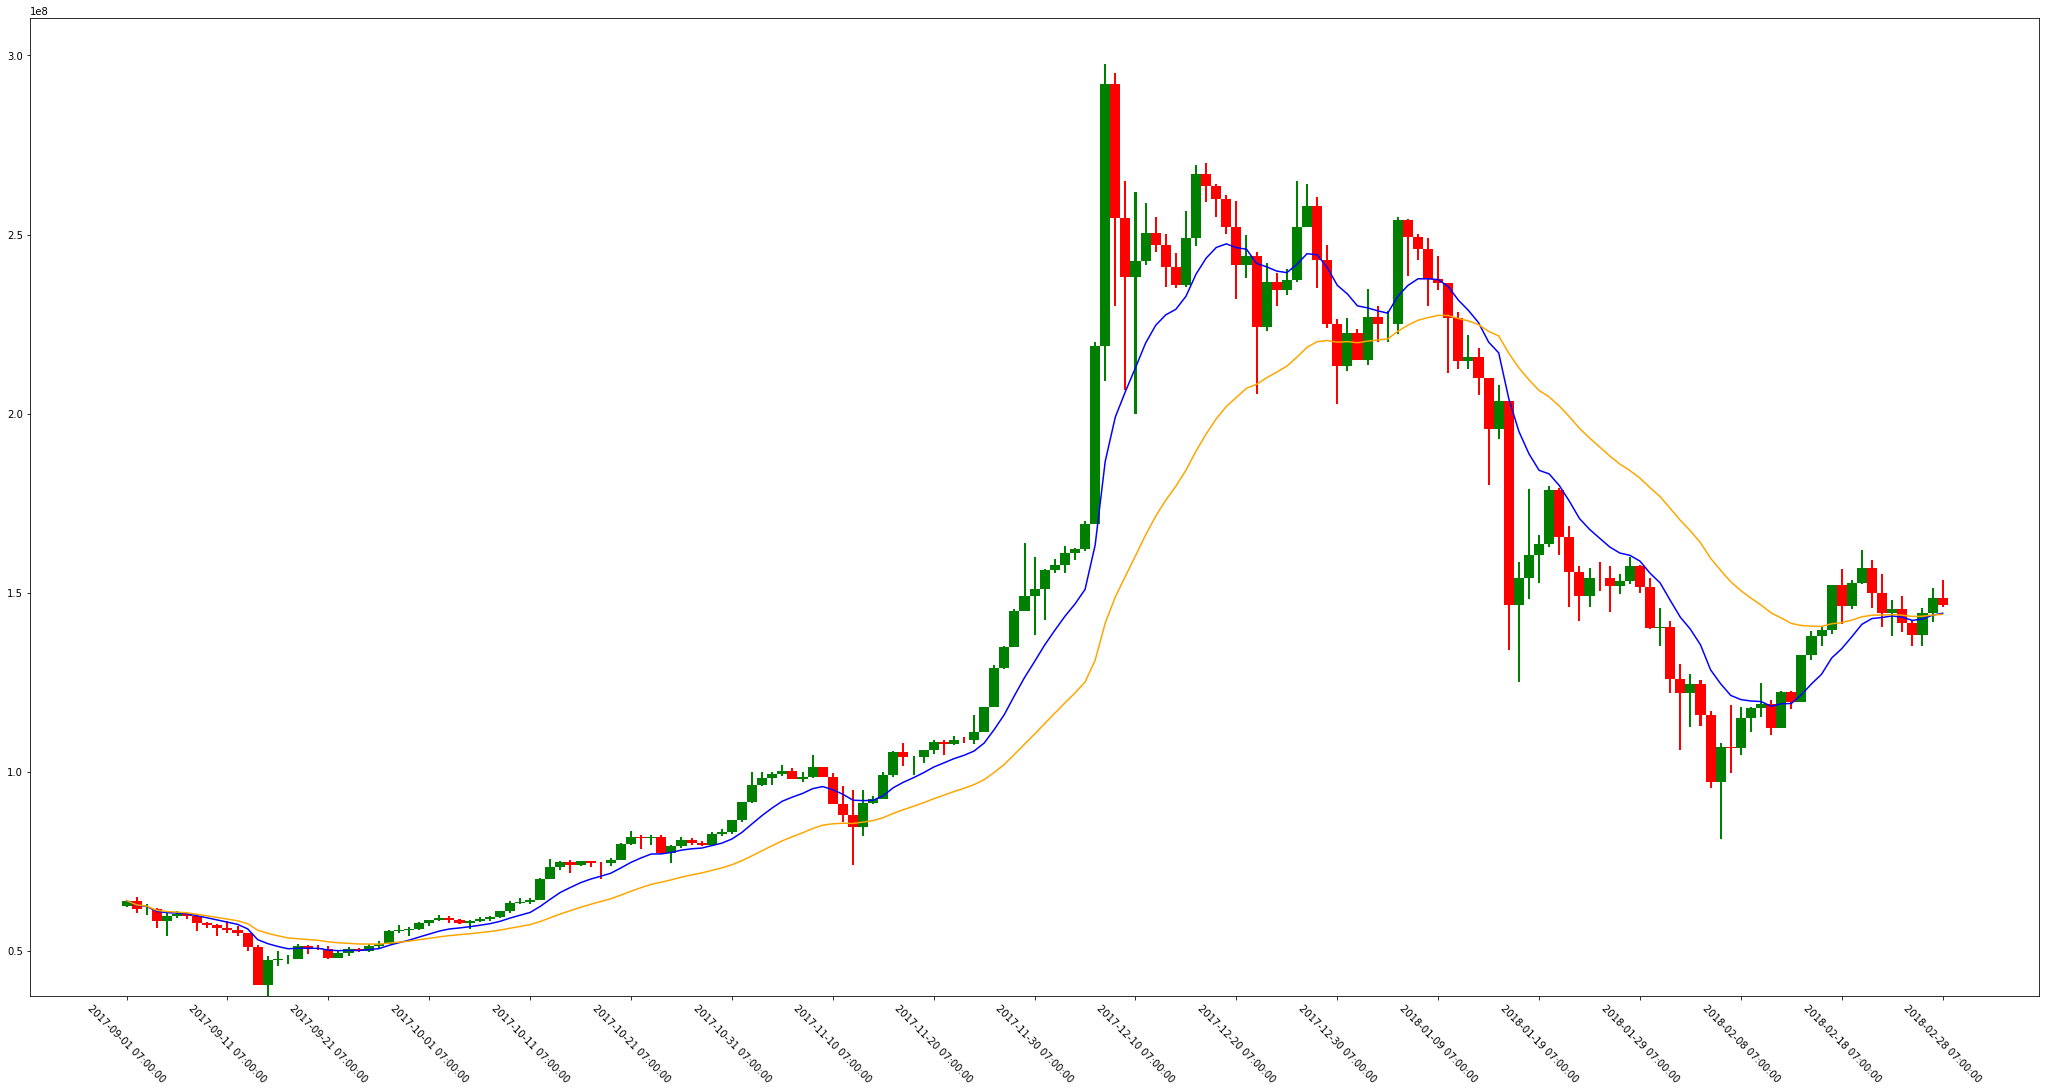

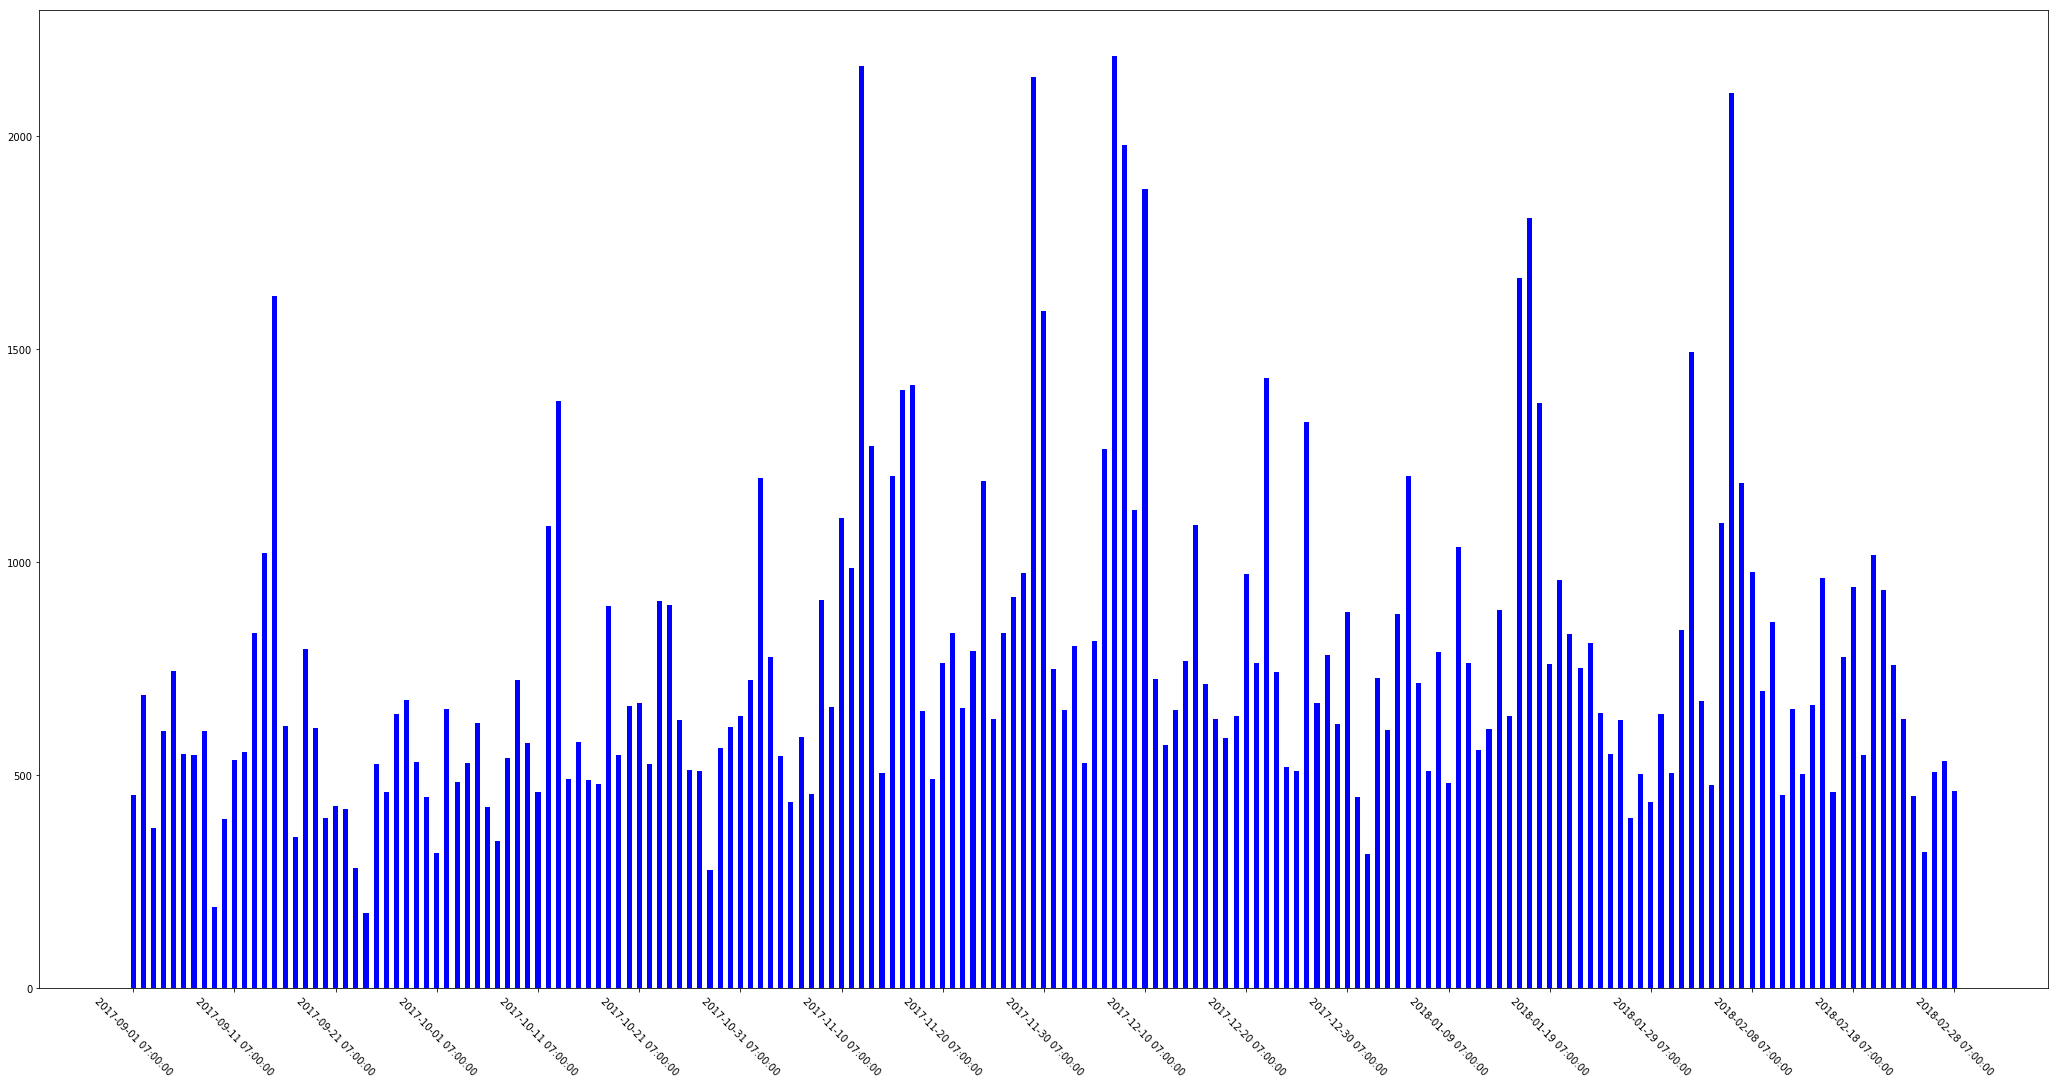

In [401]:
candle_color = lambda o, c: 'g' if c >= o else 'r'
fig_w = len(price.open)//5
fig_h = fig_w // 2
plt.figure(figsize=(fig_w, fig_h))
plt.bar( [i for i in range(len(price.open))],
        [abs(c-o) for c,o in zip(price.close, price.open)],
        [1 for i in range(len(price.open))],
        [min(c, o) for c,o in zip(price.close, price.open)],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.bar( [i for i in range(len(price.high))],
        [h-l for h,l in zip(price.high, price.low)],
        [.2 for i in range(len(price.high))],
        [l for l in price.low],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=10).mean(), color='blue')
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=30).mean(), color='orange')
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)
plt.figure(figsize=(fig_w, fig_h))
plt.bar([i for i in range(len(price.volume))],
        price.volume,
        .5,
        color='blue'
)
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)

#use this to visualize
plt.show()

In [104]:
action_list = {}
action_list['\\'] = {'action'}
action_list['action'] = []

# weird workaround due to limitation to column name, see below
# HOLD --> 0
# BUY --> -1
# SELL --> 1
for i in range(len(price.index)-1):
    current = price.iloc[i]
    before = price.iloc[i-1]
    after = price.iloc[i+1]
    if current.close < after.close:
        if current.close > before.close:
            action_list['action'].append(0)
        else:
            action_list['action'].append(-1)
    elif current.close > after.close:
        if current.close < before.close:
            action_list['action'].append(0)
        else:
            action_list['action'].append(1)
    else:
        action_list['action'].append(0)
action_list['action'].append(0)
action_frame = pd.DataFrame(action_list['action']).set_index(price.index)

# we need the stock price somehow
action_frame = action_frame.join(price)

# column names change 'Action' to 'low'
# weird workaround due to limitation to column name
# reference : https://www.backtrader.com/docu/pandas-datafeed/pandas-datafeed.html?highlight=pandasdata
action_frame.columns = ['low', 'open', 'close', 'high', 'real_low', 'volume']

# Labeling

In [198]:
close = np.array(price.close)
label = [0 for i in range(len(close))]
profit = [0 for i in range(len(close))]
t_forward = 10
commission = 0.003
min_net_profit = lambda p: p * (1+(2*commission))
for i in range(t_forward, len(price)):
    # sample the future
    sample = np.array([close[i-j] for j in range(5)])
    profit[i-t_forward] = close[t_forward] - sample.mean() - (close[t_forward] * commission) - (close[i] * commission)
    if (sample > min_net_profit(close[i-t_forward])).sum() > 4:
        label[i-t_forward] = -1
        label[i] = 1

### Just the profits

In [208]:
close = np.array(price.close)
profit = [0 for i in range(len(close))]
t_forward = 30
for i in range(t_forward, len(price)):
    # sample the future
    sample = np.array([close[i-j] for j in range(15)])
    profit[i-t_forward] = (sample.mean() - close[i]) / close[i]

In [181]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 2043
hold 39617
sell 1829


In [209]:
plt.plot(profit)
plt.plot([0 for i in range(len(profit))])

## Label Balancing
More buy

In [182]:
state = 'not buying'
now = 0
for i in range(len(price)-t_forward, -1, -1):
    if state == 'not buying' and label[i] == -1:
        state = 'buying'
        now = close[i]
    if state == 'buying' and label[i] != -1:
        state = 'buy more'
    if state == 'buy more':
        if close[i] <= now:
            now = price.close[i]
            label[i] = -1
        else:
            state = 'not buying'

In [183]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 2611
hold 39103
sell 1775


More sell

In [184]:
state = 'not selling'
now = 0
for i in range(t_forward, len(close)):
    if state == 'not selling' and label[i] == 1:
        state = 'selling'
        now = close[i]
    if state == 'selling' and label[i] != 1:
        state = 'sell more'
    if state == 'sell more':
        if close[i] <= now:
            now = price.close[i]
            label[i] = 1
        else:
            state = 'not selling'

In [185]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 2493
hold 38554
sell 2442


In [186]:
action_frame.low = label

In [7]:
import backtrader as bt
import backtrader.feeds as btfeeds

In [187]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # weird workaround due to limitation to column name
        # we take the low column as action
        self.data_action = self.datas[0].low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.opsize = order.executed.size
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                gross_pnl = (order.executed.price - self.buyprice) * \
                    self.opsize

                net_pnl = gross_pnl - self.buycomm - order.executed.comm
                self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                         (gross_pnl, net_pnl))


            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy!
            if self.data_action[0] == -1:
                self.log('BUY CREATE')
                self.order = self.buy()

        else:
            # sell!
            if self.data_action[0] == 1:
                self.log('SELL CREATE')
                self.order = self.sell()

In [188]:
# data_feed = btfeeds.PandasData(dataname=price, openinterest=None)
data_feed = btfeeds.PandasData(dataname=action_frame, openinterest=None)
#print(data_feed)

In [189]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed)
# cerebro.adddata(action_frame)
cerebro.broker.setcash(100000000.0)
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
startingPortofolio = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
finalPortofolio = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

Starting Portfolio Value: 100000000.00
2017-01-01, BUY CREATE
2017-01-01, BUY EXECUTED, Price: 12965000.00, Cost: 12965000.00, Comm 38895.00
2017-01-01, SELL CREATE
2017-01-01, SELL EXECUTED, Price: 13086600.00, Cost: 12965000.00, Comm 39259.80
2017-01-01, OPERATION PROFIT, GROSS 121600.00, NET 43445.20
2017-01-01, BUY CREATE
2017-01-01, BUY EXECUTED, Price: 13099900.00, Cost: 13099900.00, Comm 39299.70
2017-01-02, SELL CREATE
2017-01-02, SELL EXECUTED, Price: 13250000.00, Cost: 13099900.00, Comm 39750.00
2017-01-02, OPERATION PROFIT, GROSS 150100.00, NET 71050.30
2017-01-02, BUY CREATE
2017-01-02, BUY EXECUTED, Price: 13200000.00, Cost: 13200000.00, Comm 39600.00
2017-01-02, SELL CREATE
2017-01-02, SELL EXECUTED, Price: 13299600.00, Cost: 13200000.00, Comm 39898.80
2017-01-02, OPERATION PROFIT, GROSS 99600.00, NET 20101.20
2017-01-02, BUY CREATE
2017-01-02, BUY EXECUTED, Price: 13670100.00, Cost: 13670100.00, Comm 41010.30
2017-01-02, SELL CREATE
2017-01-02, SELL EXECUTED, Price: 1378

2017-01-09, SELL CREATE
2017-01-09, SELL EXECUTED, Price: 12433900.00, Cost: 12316000.00, Comm 37301.70
2017-01-09, OPERATION PROFIT, GROSS 117900.00, NET 43650.30
2017-01-09, BUY CREATE
2017-01-09, BUY EXECUTED, Price: 12324900.00, Cost: 12324900.00, Comm 36974.70
2017-01-09, SELL CREATE
2017-01-09, SELL EXECUTED, Price: 12427500.00, Cost: 12324900.00, Comm 37282.50
2017-01-09, OPERATION PROFIT, GROSS 102600.00, NET 28342.80
2017-01-09, BUY CREATE
2017-01-09, BUY EXECUTED, Price: 12000300.00, Cost: 12000300.00, Comm 36000.90
2017-01-09, SELL CREATE
2017-01-09, SELL EXECUTED, Price: 12111000.00, Cost: 12000300.00, Comm 36333.00
2017-01-09, OPERATION PROFIT, GROSS 110700.00, NET 38366.10
2017-01-09, BUY CREATE
2017-01-09, BUY EXECUTED, Price: 12100400.00, Cost: 12100400.00, Comm 36301.20
2017-01-09, SELL CREATE
2017-01-09, SELL EXECUTED, Price: 12295000.00, Cost: 12100400.00, Comm 36885.00
2017-01-09, OPERATION PROFIT, GROSS 194600.00, NET 121413.80
2017-01-10, BUY CREATE
2017-01-10, BU

2017-01-17, BUY CREATE
2017-01-17, BUY EXECUTED, Price: 11701100.00, Cost: 11701100.00, Comm 35103.30
2017-01-18, SELL CREATE
2017-01-18, SELL EXECUTED, Price: 11880000.00, Cost: 11701100.00, Comm 35640.00
2017-01-18, OPERATION PROFIT, GROSS 178900.00, NET 108156.70
2017-01-18, BUY CREATE
2017-01-18, BUY EXECUTED, Price: 11762000.00, Cost: 11762000.00, Comm 35286.00
2017-01-18, SELL CREATE
2017-01-18, SELL EXECUTED, Price: 11859900.00, Cost: 11762000.00, Comm 35579.70
2017-01-18, OPERATION PROFIT, GROSS 97900.00, NET 27034.30
2017-01-18, BUY CREATE
2017-01-18, BUY EXECUTED, Price: 11860000.00, Cost: 11860000.00, Comm 35580.00
2017-01-18, SELL CREATE
2017-01-18, SELL EXECUTED, Price: 11936000.00, Cost: 11860000.00, Comm 35808.00
2017-01-18, OPERATION PROFIT, GROSS 76000.00, NET 4612.00
2017-01-18, BUY CREATE
2017-01-18, BUY EXECUTED, Price: 11825700.00, Cost: 11825700.00, Comm 35477.10
2017-01-18, SELL CREATE
2017-01-18, SELL EXECUTED, Price: 12067700.00, Cost: 11825700.00, Comm 36203.1

2017-02-06, BUY CREATE
2017-02-06, BUY EXECUTED, Price: 13309900.00, Cost: 13309900.00, Comm 39929.70
2017-02-06, SELL CREATE
2017-02-06, SELL EXECUTED, Price: 13400000.00, Cost: 13309900.00, Comm 40200.00
2017-02-06, OPERATION PROFIT, GROSS 90100.00, NET 9970.30
2017-02-07, BUY CREATE
2017-02-07, BUY EXECUTED, Price: 13468600.00, Cost: 13468600.00, Comm 40405.80
2017-02-07, SELL CREATE
2017-02-07, SELL EXECUTED, Price: 13649800.00, Cost: 13468600.00, Comm 40949.40
2017-02-07, OPERATION PROFIT, GROSS 181200.00, NET 99844.80
2017-02-07, BUY CREATE
2017-02-07, BUY EXECUTED, Price: 13652300.00, Cost: 13652300.00, Comm 40956.90
2017-02-07, SELL CREATE
2017-02-07, SELL EXECUTED, Price: 13949500.00, Cost: 13652300.00, Comm 41848.50
2017-02-07, OPERATION PROFIT, GROSS 297200.00, NET 214394.60
2017-02-07, BUY CREATE
2017-02-07, BUY EXECUTED, Price: 13650600.00, Cost: 13650600.00, Comm 40951.80
2017-02-07, SELL CREATE
2017-02-07, SELL EXECUTED, Price: 13799300.00, Cost: 13650600.00, Comm 41397.

2017-02-24, BUY CREATE
2017-02-24, BUY EXECUTED, Price: 15005100.00, Cost: 15005100.00, Comm 45015.30
2017-02-24, SELL CREATE
2017-02-24, SELL EXECUTED, Price: 15435000.00, Cost: 15005100.00, Comm 46305.00
2017-02-24, OPERATION PROFIT, GROSS 429900.00, NET 338579.70
2017-02-24, BUY CREATE
2017-02-24, BUY EXECUTED, Price: 14445800.00, Cost: 14445800.00, Comm 43337.40
2017-02-24, SELL CREATE
2017-02-24, SELL EXECUTED, Price: 14899900.00, Cost: 14445800.00, Comm 44699.70
2017-02-24, OPERATION PROFIT, GROSS 454100.00, NET 366062.90
2017-02-24, BUY CREATE
2017-02-24, BUY EXECUTED, Price: 14806000.00, Cost: 14806000.00, Comm 44418.00
2017-02-24, SELL CREATE
2017-02-24, SELL EXECUTED, Price: 14959900.00, Cost: 14806000.00, Comm 44879.70
2017-02-24, OPERATION PROFIT, GROSS 153900.00, NET 64602.30
2017-02-24, BUY CREATE
2017-02-24, BUY EXECUTED, Price: 14874300.00, Cost: 14874300.00, Comm 44622.90
2017-02-24, SELL CREATE
2017-02-24, SELL EXECUTED, Price: 15134100.00, Cost: 14874300.00, Comm 454

2017-03-12, BUY CREATE
2017-03-12, BUY EXECUTED, Price: 15790100.00, Cost: 15790100.00, Comm 47370.30
2017-03-12, SELL CREATE
2017-03-12, SELL EXECUTED, Price: 16000000.00, Cost: 15790100.00, Comm 48000.00
2017-03-12, OPERATION PROFIT, GROSS 209900.00, NET 114529.70
2017-03-12, BUY CREATE
2017-03-12, BUY EXECUTED, Price: 16039900.00, Cost: 16039900.00, Comm 48119.70
2017-03-12, SELL CREATE
2017-03-12, SELL EXECUTED, Price: 16040000.00, Cost: 16039900.00, Comm 48120.00
2017-03-12, OPERATION PROFIT, GROSS 100.00, NET -96139.70
2017-03-13, BUY CREATE
2017-03-13, BUY EXECUTED, Price: 16055300.00, Cost: 16055300.00, Comm 48165.90
2017-03-13, SELL CREATE
2017-03-13, SELL EXECUTED, Price: 16200000.00, Cost: 16055300.00, Comm 48600.00
2017-03-13, OPERATION PROFIT, GROSS 144700.00, NET 47934.10
2017-03-13, BUY CREATE
2017-03-13, BUY EXECUTED, Price: 16102100.00, Cost: 16102100.00, Comm 48306.30
2017-03-13, SELL CREATE
2017-03-13, SELL EXECUTED, Price: 16250100.00, Cost: 16102100.00, Comm 48750.

2017-03-24, BUY CREATE
2017-03-24, BUY EXECUTED, Price: 14613800.00, Cost: 14613800.00, Comm 43841.40
2017-03-24, SELL CREATE
2017-03-24, SELL EXECUTED, Price: 14714900.00, Cost: 14613800.00, Comm 44144.70
2017-03-24, OPERATION PROFIT, GROSS 101100.00, NET 13113.90
2017-03-24, BUY CREATE
2017-03-24, BUY EXECUTED, Price: 13510100.00, Cost: 13510100.00, Comm 40530.30
2017-03-24, SELL CREATE
2017-03-24, SELL EXECUTED, Price: 13835900.00, Cost: 13510100.00, Comm 41507.70
2017-03-24, OPERATION PROFIT, GROSS 325800.00, NET 243762.00
2017-03-25, BUY CREATE
2017-03-25, BUY EXECUTED, Price: 13119900.00, Cost: 13119900.00, Comm 39359.70
2017-03-25, SELL CREATE
2017-03-25, SELL EXECUTED, Price: 13350100.00, Cost: 13119900.00, Comm 40050.30
2017-03-25, OPERATION PROFIT, GROSS 230200.00, NET 150790.00
2017-03-25, BUY CREATE
2017-03-25, BUY EXECUTED, Price: 13080700.00, Cost: 13080700.00, Comm 39242.10
2017-03-25, SELL CREATE
2017-03-25, SELL EXECUTED, Price: 13180000.00, Cost: 13080700.00, Comm 395

2017-04-04, BUY CREATE
2017-04-04, BUY EXECUTED, Price: 14852300.00, Cost: 14852300.00, Comm 44556.90
2017-04-04, SELL CREATE
2017-04-04, SELL EXECUTED, Price: 15086400.00, Cost: 14852300.00, Comm 45259.20
2017-04-04, OPERATION PROFIT, GROSS 234100.00, NET 144283.90
2017-04-04, BUY CREATE
2017-04-04, BUY EXECUTED, Price: 15099100.00, Cost: 15099100.00, Comm 45297.30
2017-04-04, SELL CREATE
2017-04-04, SELL EXECUTED, Price: 15220800.00, Cost: 15099100.00, Comm 45662.40
2017-04-04, OPERATION PROFIT, GROSS 121700.00, NET 30740.30
2017-04-05, BUY CREATE
2017-04-05, BUY EXECUTED, Price: 14913200.00, Cost: 14913200.00, Comm 44739.60
2017-04-05, SELL CREATE
2017-04-05, SELL EXECUTED, Price: 15057200.00, Cost: 14913200.00, Comm 45171.60
2017-04-05, OPERATION PROFIT, GROSS 144000.00, NET 54088.80
2017-04-06, BUY CREATE
2017-04-06, BUY EXECUTED, Price: 14984300.00, Cost: 14984300.00, Comm 44952.90
2017-04-06, SELL CREATE
2017-04-06, SELL EXECUTED, Price: 15099000.00, Cost: 14984300.00, Comm 4529

2017-05-08, BUY CREATE
2017-05-08, BUY EXECUTED, Price: 20960400.00, Cost: 20960400.00, Comm 62881.20
2017-05-08, SELL CREATE
2017-05-08, SELL EXECUTED, Price: 21476800.00, Cost: 20960400.00, Comm 64430.40
2017-05-08, OPERATION PROFIT, GROSS 516400.00, NET 389088.40
2017-05-08, BUY CREATE
2017-05-08, BUY EXECUTED, Price: 21351400.00, Cost: 21351400.00, Comm 64054.20
2017-05-08, SELL CREATE
2017-05-08, SELL EXECUTED, Price: 21499900.00, Cost: 21351400.00, Comm 64499.70
2017-05-08, OPERATION PROFIT, GROSS 148500.00, NET 19946.10
2017-05-08, BUY CREATE
2017-05-08, BUY EXECUTED, Price: 21350000.00, Cost: 21350000.00, Comm 64050.00
2017-05-08, SELL CREATE
2017-05-08, SELL EXECUTED, Price: 21566700.00, Cost: 21350000.00, Comm 64700.10
2017-05-08, OPERATION PROFIT, GROSS 216700.00, NET 87949.90
2017-05-08, BUY CREATE
2017-05-08, BUY EXECUTED, Price: 21635600.00, Cost: 21635600.00, Comm 64906.80
2017-05-08, SELL CREATE
2017-05-08, SELL EXECUTED, Price: 22100100.00, Cost: 21635600.00, Comm 6630

2017-05-17, BUY CREATE
2017-05-17, BUY EXECUTED, Price: 24910000.00, Cost: 24910000.00, Comm 74730.00
2017-05-17, SELL CREATE
2017-05-17, SELL EXECUTED, Price: 25241100.00, Cost: 24910000.00, Comm 75723.30
2017-05-17, OPERATION PROFIT, GROSS 331100.00, NET 180646.70
2017-05-17, BUY CREATE
2017-05-17, BUY EXECUTED, Price: 25500100.00, Cost: 25500100.00, Comm 76500.30
2017-05-17, SELL CREATE
2017-05-17, SELL EXECUTED, Price: 26149900.00, Cost: 25500100.00, Comm 78449.70
2017-05-17, OPERATION PROFIT, GROSS 649800.00, NET 494850.00
2017-05-18, BUY CREATE
2017-05-18, BUY EXECUTED, Price: 25800000.00, Cost: 25800000.00, Comm 77400.00
2017-05-18, SELL CREATE
2017-05-18, SELL EXECUTED, Price: 25999800.00, Cost: 25800000.00, Comm 77999.40
2017-05-18, OPERATION PROFIT, GROSS 199800.00, NET 44400.60
2017-05-18, BUY CREATE
2017-05-18, BUY EXECUTED, Price: 25710100.00, Cost: 25710100.00, Comm 77130.30
2017-05-18, SELL CREATE
2017-05-18, SELL EXECUTED, Price: 25980000.00, Cost: 25710100.00, Comm 779

2017-05-26, BUY EXECUTED, Price: 38209900.00, Cost: 38209900.00, Comm 114629.70
2017-05-26, SELL CREATE
2017-05-26, SELL EXECUTED, Price: 39300500.00, Cost: 38209900.00, Comm 117901.50
2017-05-26, OPERATION PROFIT, GROSS 1090600.00, NET 858068.80
2017-05-26, BUY CREATE
2017-05-26, BUY EXECUTED, Price: 36494800.00, Cost: 36494800.00, Comm 109484.40
2017-05-26, SELL CREATE
2017-05-26, SELL EXECUTED, Price: 38625000.00, Cost: 36494800.00, Comm 115875.00
2017-05-26, OPERATION PROFIT, GROSS 2130200.00, NET 1904840.60
2017-05-26, BUY CREATE
2017-05-26, BUY EXECUTED, Price: 37810900.00, Cost: 37810900.00, Comm 113432.70
2017-05-26, SELL CREATE
2017-05-26, SELL EXECUTED, Price: 38157100.00, Cost: 37810900.00, Comm 114471.30
2017-05-26, OPERATION PROFIT, GROSS 346200.00, NET 118296.00
2017-05-26, BUY CREATE
2017-05-26, BUY EXECUTED, Price: 37893100.00, Cost: 37893100.00, Comm 113679.30
2017-05-26, SELL CREATE
2017-05-26, SELL EXECUTED, Price: 38350600.00, Cost: 37893100.00, Comm 115051.80
2017-

2017-05-30, BUY CREATE
2017-05-30, BUY EXECUTED, Price: 33250100.00, Cost: 33250100.00, Comm 99750.30
2017-05-30, SELL CREATE
2017-05-30, SELL EXECUTED, Price: 33700000.00, Cost: 33250100.00, Comm 101100.00
2017-05-30, OPERATION PROFIT, GROSS 449900.00, NET 249049.70
2017-05-30, BUY CREATE
2017-05-30, BUY EXECUTED, Price: 33515000.00, Cost: 33515000.00, Comm 100545.00
2017-05-30, SELL CREATE
2017-05-30, SELL EXECUTED, Price: 34100400.00, Cost: 33515000.00, Comm 102301.20
2017-05-30, OPERATION PROFIT, GROSS 585400.00, NET 382553.80
2017-05-30, BUY CREATE
2017-05-30, BUY EXECUTED, Price: 34011000.00, Cost: 34011000.00, Comm 102033.00
2017-05-30, SELL CREATE
2017-05-30, SELL EXECUTED, Price: 34247200.00, Cost: 34011000.00, Comm 102741.60
2017-05-30, OPERATION PROFIT, GROSS 236200.00, NET 31425.40
2017-05-30, BUY CREATE
2017-05-30, BUY EXECUTED, Price: 33935000.00, Cost: 33935000.00, Comm 101805.00
2017-05-30, SELL CREATE
2017-05-30, SELL EXECUTED, Price: 34248900.00, Cost: 33935000.00, Co

In [171]:
93.952555

93.952555

In [122]:
len(action_frame)

52129

# Data Formatting

## Labels
- HOLD: 1
- BUY: 0
- SELL: 2

## Data Format #1
| Column # | Description |
| --- | --- |
| 1 | close price t |
| 2 | trade volume t |
| 3 | close price t-1 |
| 4 | trade volume t-1 |
| 5 | close price t-2 |
| 6 | trade volume t-2 |
| 7 | close price t-3 |
| 8 | trade volume t-3 |
| 9 | close price t-4 |
| 10 | trade volume t-4 |
| 11 | close price t-5 |
| 12 | trade volume t-5 |

In [78]:
train = []
for t in range(period-1, len(price)):
    now = []
    for i in range(period):
        now.append(price.close[t-i])
        now.append(price.volume[t-i])
    train.append(now)
train = np.array(train)

In [86]:
timestep = 6
target_label = keras.utils.to_categorical(np.array([i+1 for i in action_frame.low]), num_classes=3)[timestep-1:]

## Data Format #2
| Column # | Description |
| --- | --- |
| 1 | close price t |
| 2 | close price t-1 |
| .. | .. | 
| 24 | close price t-23 |

### Data normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [10]:
normalizer = StandardScaler()

In [11]:
price_normalized = normalizer.fit_transform(np.array(price.close)[:,np.newaxis])

C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
timestep = 120
target_label = keras.utils.to_categorical(np.array([i+1 for i in action_frame.low]), num_classes=3)[timestep:]

In [15]:
data = []
for t in range(timestep, len(price_normalized)):
    data.append(price_normalized[t-timestep:t])
data = np.array(data)


### Reshape for Recurrent Layer input

In [16]:
data = data.reshape((data.shape[0], timestep, 1))

# Toy Data
It is to make sure that the RNN can recognize simple pattern

In [4]:
BUY = 0
HOLD = 1
SELL = 2
INITIAL_PRICE = 50000000

def generate_hold_pattern(last_price, length):
    return (
        np.array([last_price + np.random.normal(0, 10) for i in range(length)]), # balanced data
        np.array([HOLD for i in range(length)]) # balanced data
    )

def generate_buy_pattern(last_price, length):
    return (
        np.array([last_price + np.random.normal(i*10, 1) for i in range(length)]),
        np.array([BUY for i in range(length)])
    )

def generate_sell_pattern(last_price, length):
    return (
        np.array([last_price - np.random.normal(i*10, 1) for i in range(length)]),
        np.array([SELL for i in range(length)])
    )

In [55]:
price = np.array([])
label = np.array([])
current_price = INITIAL_PRICE
generators = [generate_hold_pattern, generate_buy_pattern, generate_sell_pattern]
for i in range(100):
    np.random.shuffle(generators)
    for f in generators:
        p, l = f(current_price, np.random.randint(15, 25))
        price = np.append(price, p)
        label = np.append(label, l)
        current_price = p[-1]

In [121]:
len(action_list)

2

# Real Data Preparation

## Labeling

In [25]:
from sklearn.preprocessing import StandardScaler

In [190]:
X = np.array(price.close)
y = (np.array(action_frame.low) + 1)[:-t_forward]

In [119]:
timestep = t_forward
ts = []
for t in range(timestep, len(X)):
    ts.append(X[t-timestep:t])
ts = np.array(ts)

In [120]:
ts.shape

(43479, 10)

In [121]:
len(y)

43479

In [27]:
test_split = len(ts) // 10 # percent
X_norm = StandardScaler().fit_transform(X.reshape(-1,1))
X_train = X_norm[:-test_split]
y_train = y[:-test_split]
X_test = X_norm[-test_split:]
y_test = y[-test_split:]

C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [48]:
len(y_train)

40177

# Visualization

In [210]:
%matplotlib qt

plt_len = 30000
plt.figure(figsize=(40, 5))
plt.plot(X[:plt_len])
plt.figure(figsize=(40, 5))
plt.plot(profit[:plt_len])
plt.plot([0 for i in range(plt_len)])
plt.figure(figsize=(40, 5))
plt.scatter(
    [i for i in range((plt_len))],
    [0 for i in range((plt_len))],
    color=[(1 if i == 2 else 0, 1 if i == 0 else 0, 1 if i == 1 else 0) for i in y[:plt_len]],
    s=5
)

### RNN

In [92]:
data = data.reshape((data.shape[0], timestep, 1))
target_label = keras.utils.to_categorical(np.array([i for i in label]), num_classes=3)[timestep:]

In [95]:
for i in range(1, 5830):
    if 5830 % i == 0:
        print(i)

1
2
5
10
11
22
53
55
106
110
265
530
583
1166
2915


### Others

In [36]:
train_data = data.T[0].T

In [41]:
train_data.shape

(40157, 20)

In [45]:
y_train[:20]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

# Machine Learning Model: SVM

In [39]:
from sklearn.svm import SVC

In [40]:
clf = SVC()

In [89]:
clf.fit(X_train, y_train)

C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [91]:
clf.score(X, y)

0.8276157804459692

# Machine Learning Model: Gradient Boosting

In [109]:
from sklearn.ensemble import GradientBoostingClassifier

In [114]:
clf = GradientBoostingClassifier(n_estimators=200)

In [115]:
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [116]:
clf.score(X,y)

0.9060034305317324

# Machine Learning Model: RNN
4 Layers of Fully connected neural network + 1 softmax layer

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN, BatchNormalization, LSTM

### Must set correct batch size
Length of training data must be divisible by batch size

In [96]:
correct_batch_size = 530

In [105]:
def generate_recurrent_layers(units, layers_count):
    return [SimpleRNN(units, return_sequences=True) for i in range(layers_count-1)] + [SimpleRNN(units)]

def generate_fully_connected_layers(units, layers_count, activation='sigmoid'):
    return [Dense(units, activation=activation) for i in range(layers_count)]

def generate_model(batch_size=1):
    return Sequential([
        LSTM(48, activation='relu', return_sequences=True, stateful=True, batch_input_shape=(batch_size, data.shape[1], data.shape[2])),
        BatchNormalization(),
        LSTM(40, activation='relu', return_sequences=True, stateful=True),
        BatchNormalization(),
        LSTM(32, activation='relu', return_sequences=True, stateful=True),
        BatchNormalization(),
        LSTM(24, activation='relu', return_sequences=True, stateful=True),
        BatchNormalization(),
        SimpleRNN(16, activation='relu',),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])

In [106]:
model = generate_model(batch_size=correct_batch_size)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (530, 20, 48)             9600      
_________________________________________________________________
batch_normalization_17 (Batc (530, 20, 48)             192       
_________________________________________________________________
lstm_18 (LSTM)               (530, 20, 40)             14240     
_________________________________________________________________
batch_normalization_18 (Batc (530, 20, 40)             160       
_________________________________________________________________
lstm_19 (LSTM)               (530, 20, 32)             9344      
_________________________________________________________________
batch_normalization_19 (Batc (530, 20, 32)             128       
_________________________________________________________________
lstm_20 (LSTM)               (530, 20, 24)             5472      
__________

In [107]:
#keras.utils.plot_model(model)

# Model Training

In [108]:
for i in range(10):
    model.fit(data, target_label, epochs=i+1, batch_size=correct_batch_size, verbose=1, shuffle=False, initial_epoch=i)
    model.reset_states()

Epoch 1/1
5830/5830 [==============================] - 7s 1ms/step - loss: 1.3365 - acc: 0.3494TA: 5s - loss: 1.4317 - acc: 0
Epoch 2/2
5830/5830 [==============================] - 2s 343us/step - loss: 1.2048 - acc: 0.3180
Epoch 3/3
5830/5830 [==============================] - 2s 342us/step - loss: 1.1639 - acc: 0.3424
Epoch 4/4
5830/5830 [==============================] - 2s 346us/step - loss: 1.1302 - acc: 0.3357 0s - loss: 1.1287 - acc: 0.33
Epoch 5/5
5830/5830 [==============================] - 2s 344us/step - loss: 1.1266 - acc: 0.3623
Epoch 6/6
5830/5830 [==============================] - 2s 334us/step - loss: 1.1523 - acc: 0.3465
Epoch 7/7
5830/5830 [==============================] - 2s 338us/step - loss: 1.1205 - acc: 0.3429
Epoch 8/8
5830/5830 [==============================] - 2s 335us/step - loss: 1.1100 - acc: 0.3569
Epoch 9/9
5830/5830 [==============================] - 2s 338us/step - loss: 1.1087 - acc: 0.3621
Epoch 10/10
5830/5830 [==============================] - 2s 

# Create Prediction Model

In [147]:
pred_model = generate_model(batch_size=1)
pred_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [148]:
training_weights = model.get_weights()
pred_model.set_weights(training_weights)

# Prediction using trained model

In [149]:
# online forecast
correct = 0
sample_point = np.random.randint(0, 14000)
for i in range(sample_point, sample_point+20):
    if i % 10 == 0:
        print('.', end='')
    testX, testy = data[i], target_label[i]
    testX = testX.reshape(1, timestep, 1)
    yhat = pred_model.predict(testX, batch_size=correct_batch_size)
    print(
        '>Expected={}, Predicted={}'.format(
            'buy' if all(testy == np.array([1,0,0])) else ('hold' if all(testy == np.array([0,1,0])) else 'sell'),
            'buy' if np.argmax(yhat) == 0 else ('hold' if np.argmax(yhat) == 1 else 'sell')
        )
    )
    if (np.argmax(testy) == np.argmax(yhat)):
        correct += 1
print()
print('sample accuracy =', correct/100)

>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
.>Expected=sell, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
.>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold

sample accuracy = 0.12


In [405]:
np.argmax([1,2,3])

2

In [146]:
count1 = 0
for t in target_label:
    if all(t == np.array([1,0,0])):
        count1 += 1
count1/len(target_label)

0.3322267620020429